# Fetching and saving price data

In [87]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define tickers and date range
assets = ['GLD', 'SLV', 'COPX']
start_date = '2010-01-01'
end_date = '2024-12-31'

# Download adjusted closing prices for selected ETFs
def fetch_data(ticker):
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    df = df[['Close']].rename(columns={'Close': ticker})
    return df

# Fetch and combine all assets
price_data = pd.concat([fetch_data(ticker) for ticker in assets], axis=1)
price_data.dropna(inplace=True)
price_data.to_csv('commodity_etf_prices.csv')  # Save to CSV

print("Sample of historical prices:")
print(price_data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Sample of historical prices:
Price              GLD        SLV       COPX
Ticker             GLD        SLV       COPX
Date                                        
2010-04-20  111.459999  17.480000  32.046085
2010-04-21  112.309998  17.770000  31.543993
2010-04-22  111.839996  17.639999  31.369358
2010-04-23  113.190002  17.910000  31.478512
2010-04-26  112.750000  17.930000  31.958757


# Generating trend-following signals (20/50-day moving average crossover)

In [89]:
def generate_signals(prices, short_window=20, long_window=50):
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices
    signals['short_ma'] = prices.rolling(window=short_window).mean()
    signals['long_ma'] = prices.rolling(window=long_window).mean()
    signals['signal'] = 0  # default: no position
    signals.loc[signals.index[short_window:], 'signal'] = (
        (signals['short_ma'] > signals['long_ma']).astype(int).loc[signals.index[short_window:]]
    )

    signals['position'] = signals['signal'].diff().fillna(0)
    return signals

# Backtesting the strategy

In [92]:
# Backtest the strategy using signal and daily returns
def backtest(signals, initial_cash=10000):
    df = signals.copy()
    df['daily_return'] = df['price'].pct_change().fillna(0)
    df['strategy_return'] = df['daily_return'] * df['signal'].shift(1).fillna(0)
    df['cumulative_strategy'] = (1 + df['strategy_return']).cumprod() * initial_cash
    df['cumulative_buyhold'] = (1 + df['daily_return']).cumprod() * initial_cash
    return df

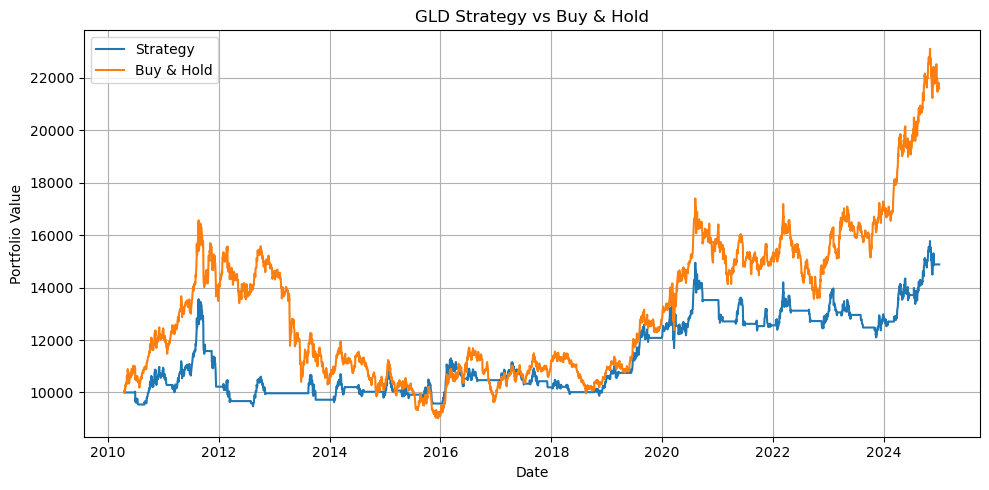

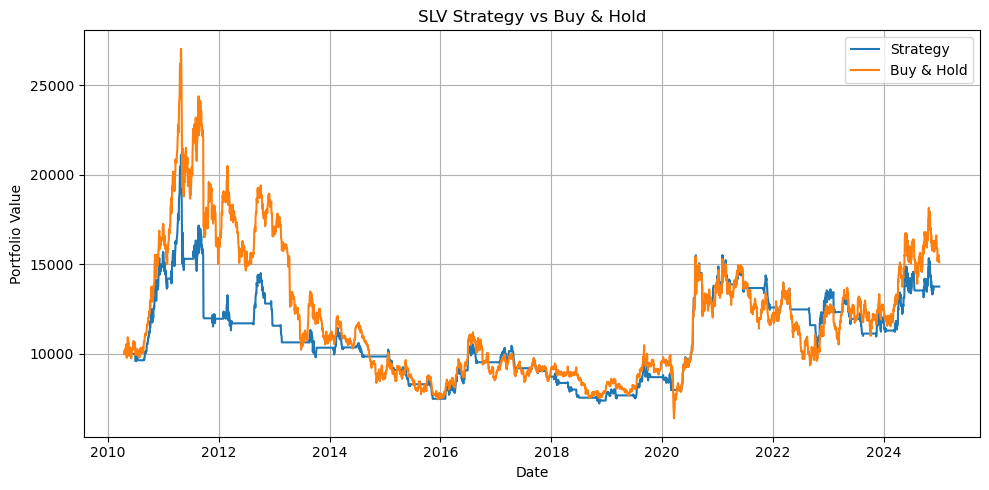

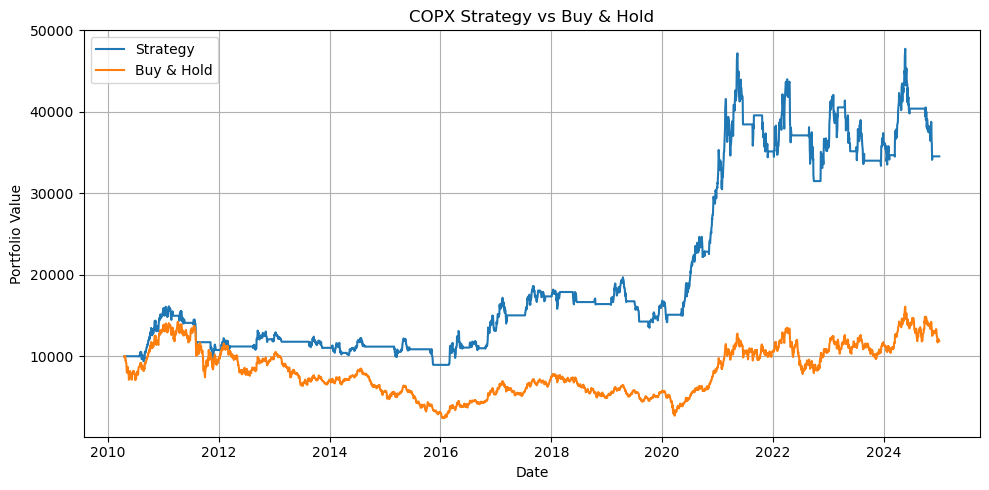

In [94]:
# Run backtest for each individual ETF and plot results
for asset in assets:
    signals = generate_signals(price_data[asset])
    result = backtest(signals)
    
    # Plot equity curves
    plt.figure(figsize=(10, 5))
    plt.plot(result['cumulative_strategy'], label='Strategy')
    plt.plot(result['cumulative_buyhold'], label='Buy & Hold')
    plt.title(f'{asset} Strategy vs Buy & Hold')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Monte Carlo simulation for future projections

In [97]:
# Monte Carlo simulation for future price paths based on historical log returns
def monte_carlo_simulation(prices, num_simulations=500, num_days=252, seed=42):
    np.random.seed(seed)
    log_returns = np.log(prices / prices.shift(1)).dropna()
    mu = log_returns.mean()
    sigma = log_returns.std()
    
    simulations = np.zeros((num_days, num_simulations))
    
    for i in range(num_simulations):
        simulated_returns = np.random.normal(mu, sigma, num_days)
        last_price = float(prices.iloc[-1])  # Convert to float scalar
        simulated_prices = last_price * np.exp(np.cumsum(simulated_returns))
        simulations[:, i] = simulated_prices
    
    return simulations

## Visualization of results

/var/folders/8q/px5v0rdx3l1f1d4sq9032ybc0000gn/T/ipykernel_47099/183076329.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_price = float(prices.iloc[-1])  # Convert to float scalar


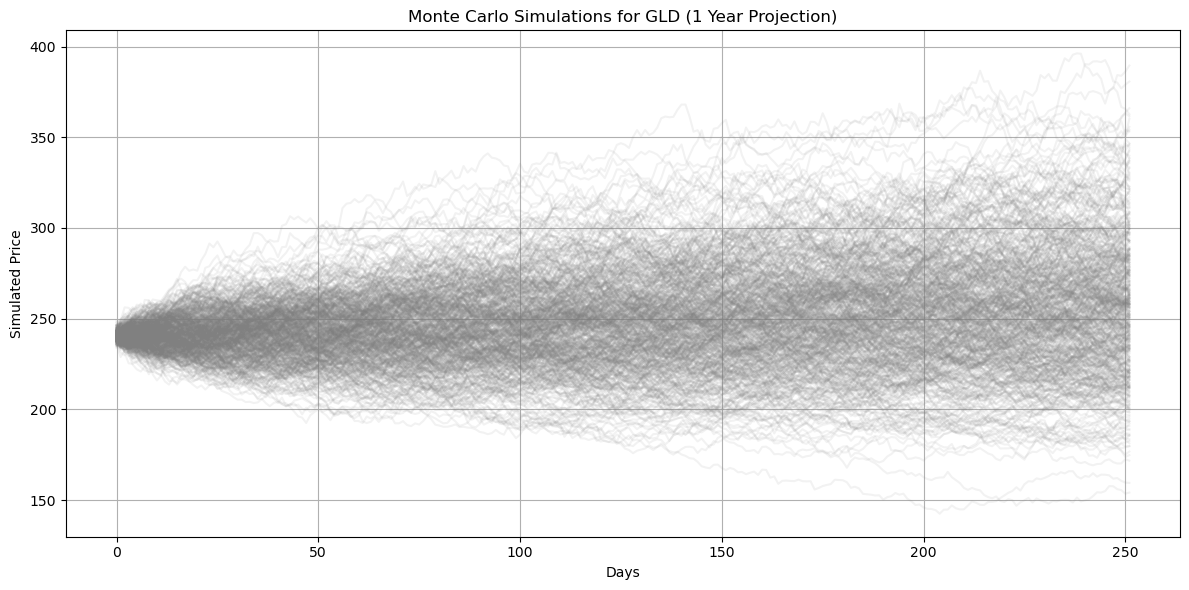

In [100]:
# Run and plot Monte Carlo simulation for one ETF (GLD)
gld_simulations = monte_carlo_simulation(price_data['GLD'])

# Plot all simulated paths
plt.figure(figsize=(12, 6))
plt.plot(gld_simulations, color='gray', alpha=0.1)
plt.title('Monte Carlo Simulations for GLD (1 Year Projection)')
plt.xlabel('Days')
plt.ylabel('Simulated Price')
plt.grid(True)
plt.tight_layout()
plt.show()

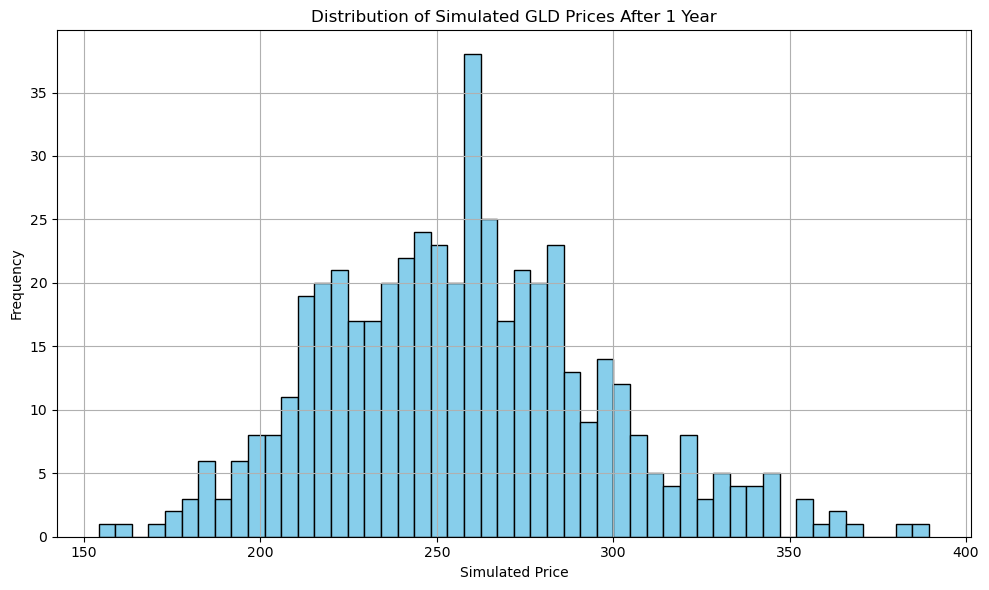

Mean final price: $257.49
Median final price: $256.66
5th percentile (VaR 95): $198.59
95th percentile: $329.07


In [102]:
# Extract final simulated prices (i.e., price at day 252 in each path)
final_prices = gld_simulations[-1, :]

# Plot histogram of final simulated prices
plt.figure(figsize=(10, 6))
plt.hist(final_prices, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Simulated GLD Prices After 1 Year")
plt.xlabel("Simulated Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary stats
print(f"Mean final price: ${final_prices.mean():.2f}")
print(f"Median final price: ${np.median(final_prices):.2f}")
print(f"5th percentile (VaR 95): ${np.percentile(final_prices, 5):.2f}")
print(f"95th percentile: ${np.percentile(final_prices, 95):.2f}")

In [104]:
# Backtest again for GLD using your earlier method
signals = generate_signals(price_data['GLD'])
bt_result = backtest(signals)

# Extract final values
final_strategy = bt_result['cumulative_strategy'].iloc[-1]
final_buyhold = bt_result['cumulative_buyhold'].iloc[-1]

print(f"Backtested Strategy Final Value: ${final_strategy:.2f}")
print(f"Buy & Hold Final Value: ${final_buyhold:.2f}")

Backtested Strategy Final Value: $14881.47
Buy & Hold Final Value: $21588.91


In [106]:
initial_investment = 10000
initial_price = price_data['GLD'].iloc[-1].item()

# Number of shares bought with 10,000
num_shares = initial_investment / initial_price

# Convert simulated prices to portfolio value
portfolio_simulations = gld_simulations * num_shares
final_values = portfolio_simulations[-1, :]

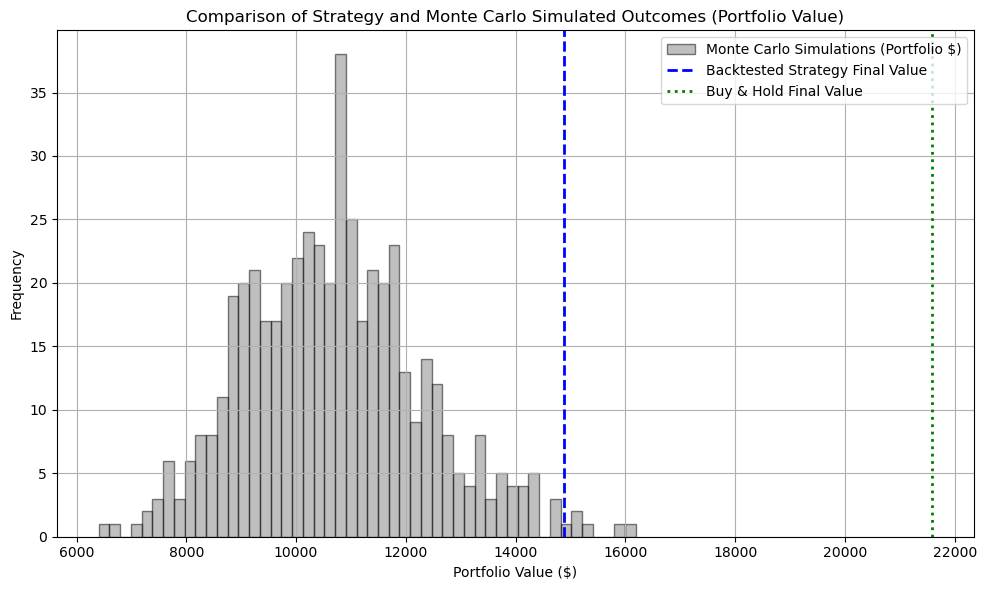

In [108]:
plt.figure(figsize=(10, 6))
plt.hist(final_values, bins=50, alpha=0.5, label='Monte Carlo Simulations (Portfolio $)', color='gray', edgecolor='black')
plt.axvline(final_strategy, color='blue', linestyle='dashed', linewidth=2, label='Backtested Strategy Final Value')
plt.axvline(final_buyhold, color='green', linestyle='dotted', linewidth=2, label='Buy & Hold Final Value')
plt.title("Comparison of Strategy and Monte Carlo Simulated Outcomes (Portfolio Value)")
plt.xlabel("Portfolio Value ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Checkpoint 3 — Benchmark / CAPM Metrics / Fees / Sensitivity

Adds S&P 500 benchmark alignment, CAPM metrics (Alpha, Beta), CAGR/Sharpe/MaxDD, a fee model, and fee sensitivity.

In [112]:

# === Benchmark, Metrics, Fees (self-contained) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def fetch_benchmark(start, end, ticker="^GSPC", auto_adjust=False):
    # Fetch benchmark prices, robust to yfinance changes. Returns DataFrame with 'benchmark' column.
    import pandas as pd
    import yfinance as yf
    df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=auto_adjust)
    if df is None or df.empty:
        raise ValueError(f"No data for {ticker} in range {start}..{end}")
    if isinstance(df.columns, pd.MultiIndex):
        col = None
        for candidate in [("Adj Close", ticker), ("Close", ticker)]:
            if candidate in df.columns:
                col = df[candidate]
                break
        if col is None:
            if "Adj Close" in df.columns.get_level_values(0):
                col = df.xs("Adj Close", axis=1, level=0).iloc[:, 0]
            elif "Close" in df.columns.get_level_values(0):
                col = df.xs("Close", axis=1, level=0).iloc[:, 0]
            else:
                col = df.select_dtypes("number").iloc[:, 0]
    else:
        if "Adj Close" in df.columns:
            col = df["Adj Close"]
        elif "Close" in df.columns:
            col = df["Close"]
        else:
            col = df.select_dtypes("number").iloc[:, 0]
    return col.dropna().rename("benchmark").to_frame()

def align_series(strategy_equity: pd.Series, benchmark_price: pd.Series):
    df = pd.concat({"strategy": strategy_equity.ffill(), "benchmark": benchmark_price.ffill()}, axis=1).dropna()
    bench_equity = (df["benchmark"] / df["benchmark"].iloc[0]) * df["strategy"].iloc[0]
    strat_rets = df["strategy"].pct_change().dropna()
    bench_rets = bench_equity.pct_change().dropna()
    aligned = pd.concat({"strategy": strat_rets, "benchmark": bench_rets}, axis=1).dropna()
    return aligned["strategy"], aligned["benchmark"]

def compute_cagr(equity: pd.Series, periods_per_year=252):
    e = equity.dropna()
    if e.empty: return np.nan
    years = (e.index[-1] - e.index[0]).days / 365.25
    if years <= 0: return np.nan
    return (e.iloc[-1] / e.iloc[0]) ** (1/years) - 1

def compute_max_drawdown(equity: pd.Series):
    run_max = equity.cummax()
    dd = equity / run_max - 1.0
    return dd.min()

def compute_sharpe(returns: pd.Series, rf=0.0, periods_per_year=252):
    ex = returns - rf/periods_per_year
    ann_ret = ex.mean() * periods_per_year
    ann_vol = ex.std(ddof=0) * np.sqrt(periods_per_year)
    return np.nan if ann_vol == 0 else ann_ret / ann_vol

def compute_alpha_beta(strat_rets: pd.Series, bench_rets: pd.Series, rf=0.0, periods_per_year=252):
    if rf != 0.0:
        strat_rets = strat_rets - rf/periods_per_year
        bench_rets = bench_rets - rf/periods_per_year
    df = pd.concat({"s": strat_rets, "b": bench_rets}, axis=1).dropna()
    if df.empty: return np.nan, np.nan
    b = df["b"].values; s = df["s"].values
    var_b = np.var(b, ddof=0)
    if var_b == 0: return np.nan, np.nan
    beta = np.cov(s, b, ddof=0)[0,1] / var_b
    alpha_daily = np.mean(s) - beta * np.mean(b)
    return alpha_daily * periods_per_year, beta

def apply_fees(strategy_equity: pd.Series,
               bench_rets: pd.Series | None = None,
               management_fee=0.02,
               performance_fee=0.20,
               alpha_hurdle=0.0,
               periods_per_year=252):
    e0 = strategy_equity.dropna().copy()
    if e0.empty: return e0
    daily_mgmt = (1 - management_fee) ** (1/periods_per_year)
    daily_ret = e0.pct_change().fillna(0.0)
    use_bench = isinstance(alpha_hurdle, str) and alpha_hurdle.lower() == "benchmark"
    bench_daily = None
    if use_bench:
        if bench_rets is None: raise ValueError("alpha_hurdle='benchmark' requires bench_rets")
        bench_daily = bench_rets.reindex(daily_ret.index).fillna(0.0)
    out = [e0.iloc[0]]
    cum_s, cum_b = 1.0, 1.0
    year = e0.index[0].year
    for date, r in daily_ret.iloc[1:].items():
        cum_s *= (1 + r)
        cum_s *= daily_mgmt
        if bench_daily is not None:
            cum_b *= (1 + bench_daily.loc[date])
        if date.year != year:
            if use_bench:
                excess = cum_s - cum_b
            else:
                excess = cum_s - (1 + alpha_hurdle)
            if excess > 0 and performance_fee > 0:
                cum_s -= excess * performance_fee
            year = date.year
            cum_b = 1.0
        out.append(e0.iloc[0] * cum_s)
    return pd.Series(out, index=e0.index, name="equity_after_fees")

def fee_sensitivity(strategy_equity: pd.Series, bench_prices: pd.Series,
                    mgmt_grid=(0.00,0.01,0.02,0.03,0.04),
                    perf_grid=(0.00,0.05,0.10,0.15,0.20,0.25),
                    metric="CAGR"):
    bench_equity = (bench_prices / bench_prices.iloc[0]) * strategy_equity.iloc[0]
    bench_rets = bench_equity.pct_change().dropna()
    res = pd.DataFrame(index=mgmt_grid, columns=perf_grid, dtype=float)
    for m in mgmt_grid:
        for p in perf_grid:
            eq = apply_fees(strategy_equity, bench_rets=bench_rets,
                            management_fee=m, performance_fee=p, alpha_hurdle=0.0)
            res.loc[m, p] = compute_cagr(eq) if metric.lower()=="cagr" else eq.iloc[-1]
    res.index.name = "Management Fee"; res.columns.name = "Performance Fee"
    return res

def plot_fee_sensitivity_heatmap(grid_df, title="Fee Sensitivity (CAGR)"):
    plt.figure(figsize=(8,6))
    plt.imshow(grid_df.values, aspect='auto')
    plt.colorbar(label=title)
    plt.xticks(range(grid_df.shape[1]), [f"{c:.0%}" for c in grid_df.columns], rotation=45)
    plt.yticks(range(grid_df.shape[0]), [f"{i:.0%}" for i in grid_df.index])
    plt.xlabel("Performance Fee"); plt.ylabel("Management Fee"); plt.title(title)
    plt.tight_layout(); plt.show()

def metric_report(strategy_equity: pd.Series, bench_prices: pd.Series, rf=0.0):
    strat_rets, bench_rets = align_series(strategy_equity, bench_prices)
    sharpe = compute_sharpe(strat_rets, rf=rf)
    alpha_ann, beta = compute_alpha_beta(strat_rets, bench_rets, rf=rf)
    cagr = compute_cagr(strategy_equity)
    mdd = compute_max_drawdown(strategy_equity)
    bench_eq = (bench_prices / bench_prices.iloc[0]) * strategy_equity.iloc[0]
    bench_cagr = compute_cagr(bench_eq)
    return pd.Series({
        "CAGR (strategy)": cagr,
        "CAGR (benchmark)": bench_cagr,
        "Sharpe": sharpe,
        "Alpha (annual)": alpha_ann,
        "Beta": beta,
        "Max Drawdown": mdd
    })


=== Metric Report (Pre-fee) ===
CAGR (strategy)     0.027418
CAGR (benchmark)    0.114977
Sharpe              0.295115
Alpha (annual)      0.032820
Beta                0.006140
Max Drawdown       -0.301193
dtype: float64

=== Metric Report (After fees: 2% mgmt / 20% perf) ===
CAGR (strategy)     0.004997
CAGR (benchmark)    0.114977
Sharpe              0.100979
Alpha (annual)      0.010726
Beta                0.006287
Max Drawdown       -0.370427
dtype: float64


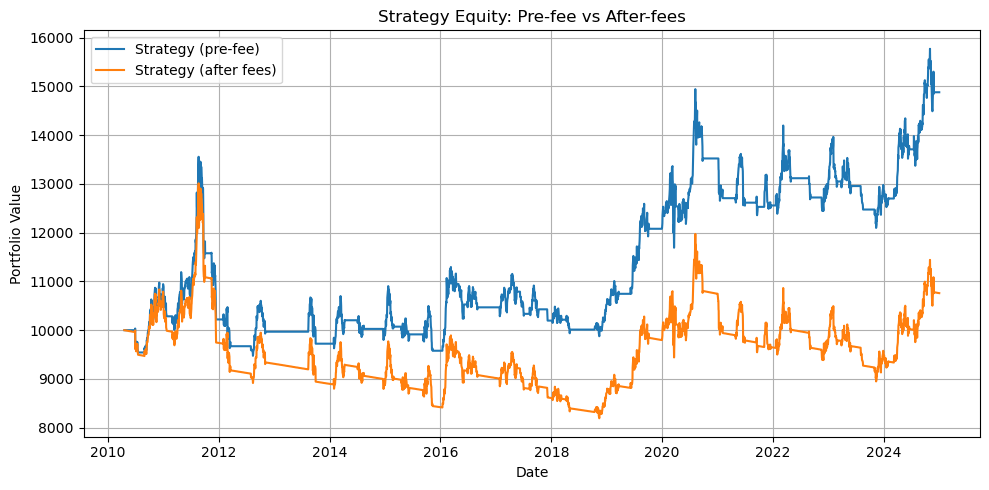


Fee sensitivity (CAGR):


Performance Fee,0.00,0.05,0.10,0.15,0.20,0.25
Management Fee,,,,,,
0.00,0.027418,0.023271,0.019975,0.017379,0.015336,0.013758
0.01,0.017157,0.014983,0.013247,0.011885,0.010844,0.010068
0.02,0.006895,0.006356,0.005885,0.005441,0.004997,0.004576
0.03,-0.003367,-0.003575,-0.003785,-0.003994,-0.004205,-0.004416
0.04,-0.013629,-0.013812,-0.013995,-0.014180,-0.014364,-0.014549


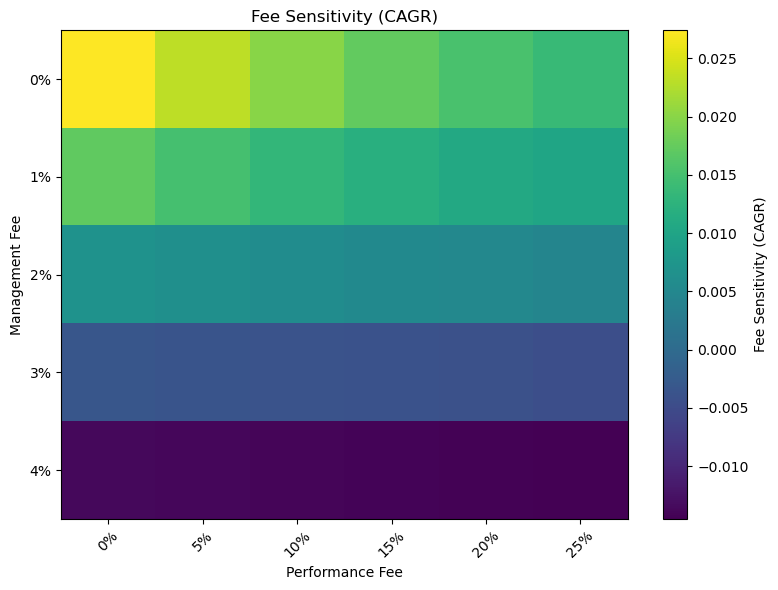

In [114]:

# === Usage with your existing variables ===
try:
    strategy_equity = bt_result['cumulative_strategy']
except Exception as _:
    signals_gld = generate_signals(price_data['GLD'])
    bt_tmp = backtest(signals_gld)
    strategy_equity = bt_tmp['cumulative_strategy']

start = str(strategy_equity.index.min().date())
end = str(strategy_equity.index.max().date())
try:
    bench_df = fetch_benchmark(start, end, ticker="^GSPC", auto_adjust=False)
except Exception:
    bench_df = fetch_benchmark(start, end, ticker="SPY", auto_adjust=False)
bench_prices = bench_df['benchmark']

report = metric_report(strategy_equity, bench_prices, rf=0.0)
print("=== Metric Report (Pre-fee) ===")
print(report)

bench_equity = (bench_prices / bench_prices.iloc[0]) * strategy_equity.iloc[0]
bench_rets = bench_equity.pct_change().dropna()
equity_after_fees = apply_fees(strategy_equity, bench_rets=bench_rets,
                               management_fee=0.02, performance_fee=0.20, alpha_hurdle=0.0)
report_after_fees = metric_report(equity_after_fees, bench_prices, rf=0.0)
print("\n=== Metric Report (After fees: 2% mgmt / 20% perf) ===")
print(report_after_fees)

plt.figure(figsize=(10,5))
plt.plot(strategy_equity, label="Strategy (pre-fee)")
plt.plot(equity_after_fees, label="Strategy (after fees)")
plt.title("Strategy Equity: Pre-fee vs After-fees")
plt.xlabel("Date"); plt.ylabel("Portfolio Value"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

grid = fee_sensitivity(strategy_equity, bench_prices,
                       mgmt_grid=(0.00,0.01,0.02,0.03,0.04),
                       perf_grid=(0.00,0.05,0.10,0.15,0.20,0.25),
                       metric="CAGR")
print("\nFee sensitivity (CAGR):")
try:
    display(grid)
except NameError:
    print(grid)
plot_fee_sensitivity_heatmap(grid, title="Fee Sensitivity (CAGR)")
